In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

In [2]:
path = "G:/My Drive/2021/Bias/sumo_simulation/appsim"
os.chdir(path)
#os.listdir()

In [4]:
#read app-based data
csv_path = '../data040420175min.csv'
#def convertobs2mx(csv_path,)
data_obs = pd.read_csv(csv_path, header=0)
data_obs.head(3)

,newid,sum,key,taz,date,time
0,26,1,4_3_55_608,608,4,3:55
1,26,2,4_4_5_615,615,4,4:05
2,26,1,4_3_40_578,578,4,3:40


In [5]:
newids = np.unique(data_obs.newid)
newid_ = {}
index_ = 0
for i in range(len(newids)):
    newid_[newids[i]] = index_
    index_ += 1

In [6]:
get_hr = lambda x: x.split(':')[0]
get_min = lambda x: x.split(':')[1]

hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
taz_ = np.unique(data_obs['taz'])

In [7]:
index_ = 0
lt_loc = {}
for taz in taz_:
    for h in hr_:
        for m in min_:
            lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
            index_ += 1
obs_mx = np.zeros((len(newid_), len(lt_loc)))

newid_col = data_obs.newid.values
key_col = data_obs.key.values

In [8]:
ct_col = data_obs['sum'].values

In [9]:
for i in range(len(newid_col)):
    obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

In [10]:
print(len(taz_))

167


In [11]:
total_ct = np.sum(obs_mx, axis=0)
#get ct based on taz and time

In [12]:
total_ct = total_ct.reshape(1, total_ct.shape[0])

In [13]:
total_ct_conver = np.hsplit(total_ct, len(taz_))

In [14]:
max_num = np.max(np.array(total_ct_conver), axis=2)

In [15]:
max_num.shape[0]

167

In [129]:
for i in range(max_num.shape):
    max_num

167

In [16]:
(np.array(total_ct_conver)/np.max(total_ct_conver, axis=2)).shape

(167, 167, 288)

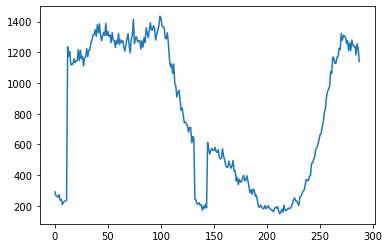

In [17]:
plt.plot(data_obs.groupby(by=['time']).size().values)

In [ ]:
#example of NMF
#X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [19]:
#convert dt to matrix
def convert2mx(fcd_dt_path, savepath, save_index=False):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    fcd_out.time = fcd_out.time.astype('int')
    print('num id', len(np.unique(fcd_out.id)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)

    fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    time_ = np.unique((fcd_out['time']/300).astype(int))
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.id):
        newuser_[i] = index_
        index_ += 1

    loc_time = {}
    index_ = 0
    taz_ = np.unique(fcd_out['taz'])
    time_ = np.unique((fcd_out['time']/300).astype(int))
    for taz in taz_:
        for t in time_:
            loc_time[str(taz)+'_'+str(t)] = index_
            index_ += 1

    origin_dt = np.zeros((len(newuser_), len(loc_time)))
    ids_ = fcd_out['id'].values
    tl_id_ = fcd_out['tl_id'].values
    for i in range(len(ids_)):
        origin_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = 1
    if save_index == True:
        pd.DataFrame(origin_dt).to_csv(savepath)
    else:
        return(origin_dt)
    
origin_dt = convert2mx('fcd_data_5.csv', 'origin_dt.csv', save_index=False)

num id 60728


In [20]:
fcd_out = pd.read_csv('fcd_data_5.csv', header=None)
fcd_out.columns = ['id', 'taz', 'time']

fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
fcd_out.taz = fcd_out.taz.astype('int')
fcd_out.time = fcd_out.time.astype('int')
fcd_out['time_5'] = fcd_out.time/300


In [21]:
fcd_out.time_5 = fcd_out.time_5.astype('int')

In [22]:
obs = data_obs.groupby(by=['time']).size().values
obs_per = obs/max(obs)

In [23]:
sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

In [24]:
fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

In [25]:
fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)

In [26]:
newuser_ = {}
index_ = 0
for i in np.unique(fcd_out.id):
    newuser_[i] = index_
    index_ += 1

loc_time = {}
index_ = 0
taz_ = np.unique(fcd_out['taz'])
time_ = np.unique((fcd_out['time']/300).astype(int))
for taz in taz_:
    for t in time_:
        loc_time[str(taz)+'_'+str(t)] = index_
        index_ += 1

sim_dt = np.zeros((len(newuser_), len(loc_time)))
ids_ = fcd_out['id'].values
tl_id_ = fcd_out['tl_id'].values
ct_ = fcd_out['sim_obs'].values
for i in range(len(ids_)):
    sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = ct_[i]



In [178]:
taz_

array([426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 446, 447, 448, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 566, 567, 568, 569, 570, 571,
       572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
       604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 627,
       628, 629, 630, 631, 632, 634, 635, 636, 650, 651, 652, 653])

In [27]:
model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(sim_dt)
H = model.components_

WH = np.dot(W, H)
#therefore we have
#origin_dt (ground truth)
#sim_dt (time variation based sampling)
#WH (nmf pred based on sim_dt)

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [33]:
mean_squared_error(origin_dt, sim_dt, squared=False)

0.003269806981300681

In [34]:
mean_squared_error(origin_dt, WH, squared=False)

0.005064870617568365

In [36]:
mean_squared_error(sim_dt, WH, squared=False)

0.0028294665247159886

In [37]:
#save the predicted W and H
pd.DataFrame(W).to_csv('W_time.csv')
pd.DataFrame(H).to_csv('H_time.csv')